**SPEAKER CHANGE**

In [ ]:
import librosa
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
segLen, frameRate, maxClusters = 3, 50, 10

In [ ]:
def VoiceActivityDetection(wavData, frameRate): #analyze audio audible or not
    ste = librosa.feature.rms(y=wavData, hop_length=int(16000/frameRate)).T
    thresh = 0.1 * (np.percentile(ste, 97.5) + 9 * np.percentile(ste, 2.5))
    return (ste > thresh).astype('bool')

In [ ]:
def determineOptimalClusters(mfcc, maxClusters):
    bics = []
    for n_clusters in range(2, maxClusters+1):
        gmm = GaussianMixture(n_components=n_clusters, covariance_type='diag')
        gmm.fit(mfcc)
        bic = gmm.bic(mfcc)
        bics.append(bic)

    # Plotting the BIC scores for different numbers of clusters
    plt.plot(range(2, maxClusters+1), bics, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('BIC Score')
    plt.title('BIC Score for Different Numbers of Clusters')
    plt.show()

    # Selecting the number of clusters with the lowest BIC score
    optimalClusters = np.argmin(bics) + 2  # Adding 2 since range starts from 2
    print("Optimal Number of Clusters:", optimalClusters)
    return optimalClusters


In [ ]:
def trainGMM(wavFile, frameRate, segLen, vad, numMix):
    wavData, _ = librosa.load(wavFile, sr=16000)
    mfcc = librosa.feature.mfcc(y=wavData, sr=16000, n_mfcc=20, hop_length=int(16000/frameRate)).T
    vad = np.reshape(vad, (len(vad),))
    if mfcc.shape[0] > vad.shape[0]:
        vad = np.hstack((vad, np.zeros(mfcc.shape[0] - vad.shape[0]).astype('bool'))).astype('bool')
    elif mfcc.shape[0] < vad.shape[0]:
        vad = vad[:mfcc.shape[0]]
    mfcc = mfcc[vad, :]

    print("Determining optimal number of clusters..")
    numClusters = determineOptimalClusters(mfcc, maxClusters)

    print("Training GMM with", numClusters, "clusters..")
    GMM = GaussianMixture(n_components=numClusters, covariance_type='diag').fit(mfcc)
    var_floor = 1e-5
    segLikes = []
    segSize = frameRate * segLen
    for segI in range(int(np.ceil(float(mfcc.shape[0]) / (frameRate * segLen)))):
        startI = segI * segSize
        endI = (segI + 1) * segSize
        if endI > mfcc.shape[0]:
            endI = mfcc.shape[0] - 1
        if endI == startI:    # Reached the end of file
            break
        seg = mfcc[startI:endI, :]
        compLikes = np.sum(GMM.predict_proba(seg), 0)
        segLikes.append(compLikes / seg.shape[0])
    print("Training Done")
      # Clustering using Agglomerative Clustering
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(segLikes)
    X_normalized = normalize(X_scaled)
    cluster = AgglomerativeClustering(n_clusters=numClusters, affinity='euclidean', linkage='ward')
    clust = cluster.fit_predict(X_normalized)


    return segLikes, clust

In [ ]:
def SegmentFrame(clust, segLen, frameRate, numFrames):
    frameClust = np.zeros(numFrames)
    for clustI in range(len(clust)-1):
        frameClust[clustI*segLen*frameRate:(clustI+1)*segLen*frameRate] = clust[clustI]*np.ones(segLen*frameRate)
    frameClust[(clustI+1)*segLen*frameRate:] = clust[clustI+1]*np.ones(numFrames-(clustI+1)*segLen*frameRate)
    return frameClust

In [ ]:
def speakerdiarisationdf(hyp, frameRate, wavFile):
    audioname = []
    starttime = []
    endtime = []
    speakerlabel = []

    spkrChangePoints = np.where(hyp[:-1] != hyp[1:])[0]
    if spkrChangePoints[0] != 0 and hyp[0] != -1:
        spkrChangePoints = np.concatenate(([0], spkrChangePoints))
    spkrLabels = []
    for spkrHomoSegI in range(len(spkrChangePoints)):
        spkrLabels.append(hyp[spkrChangePoints[spkrHomoSegI]+1])
    for spkrI, spkr in enumerate(spkrLabels[:-1]):
        if spkr != -1:
            audioname.append(wavFile.split('/')[-1].split('.')[0] + ".wav")
            starttime.append((spkrChangePoints[spkrI]+1) / float(frameRate))
            endtime.append((spkrChangePoints[spkrI+1]-spkrChangePoints[spkrI]) / float(frameRate))
            speakerlabel.append("Speaker " + str(int(spkr)))
    if spkrLabels[-1] != -1:
        audioname.append(wavFile.split('/')[-1].split('.')[0] + ".wav")
        starttime.append(spkrChangePoints[-1] / float(frameRate))
        endtime.append((len(hyp) - spkrChangePoints[-1]) / float(frameRate))
        speakerlabel.append("Speaker " + str(int(spkrLabels[-1])))

    speakerdf = pd.DataFrame({"Audio": audioname, "starttime": starttime, "endtime": endtime, "speakerlabel": speakerlabel})

    spdatafinal = pd.DataFrame(columns=['Audio', 'SpeakerLabel', 'StartTime', 'EndTime'])
    i = 0
    k = 0
    j = 0
    spfind = ""
    stime = ""
    etime = ""
    for row in speakerdf.itertuples():
        if i == 0:
            spfind = row.speakerlabel
            stime = row.starttime
        else:
            if spfind == row.speakerlabel:
                etime = row.starttime
            else:
                spdatafinal.loc[k] = [wavFile.split('/')[-1].split('.')[0] + ".wav", spfind, stime, row.starttime]
                k = k + 1
                spfind = row.speakerlabel
                stime = row.starttime
        i = i + 1
    spdatafinal.loc[k] = [wavFile.split('/')[-1].split('.')[0] + ".wav", spfind, stime, etime]
    return spdatafinal

<ipython-input-21-394f9329d18a>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  wavData, _ = librosa.load(wavFile, sr=16000)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-4-9b3d0de4a70d>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  wavData, _ = librosa.load(wavFile, sr=16000)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Determining optimal number of clusters..


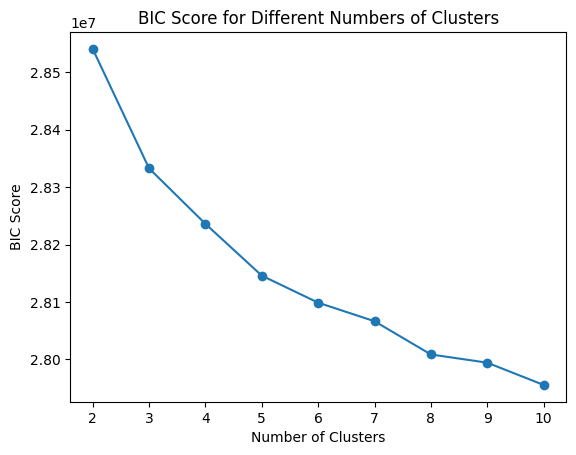

Optimal Number of Clusters: 10
Training GMM with 10 clusters..
Training Done


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [ ]:
wavFile = "/content/drive/MyDrive/FYP/audios/Checkpoint 1956.m4a"
wavData, _ = librosa.load(wavFile, sr=16000)
vad = VoiceActivityDetection(wavData, frameRate)
mfcc = librosa.feature.mfcc(y=wavData, sr=16000, n_mfcc=20, hop_length=int(16000/frameRate)).T
vad = np.reshape(vad, (len(vad),))
if mfcc.shape[0] > vad.shape[0]:
    vad = np.hstack((vad, np.zeros(mfcc.shape[0] - vad.shape[0]).astype('bool'))).astype('bool')
elif mfcc.shape[0] < vad.shape[0]:
    vad = vad[:mfcc.shape[0]]
mfcc = mfcc[vad, :]
numMix = 8  # Assign an appropriate value based on the complexity required

segLikes, clust = trainGMM(wavFile, frameRate, segLen, vad, numMix)

frameClust = SegmentFrame(clust, segLen, frameRate, mfcc.shape[0])

pass1hyp = -1 * np.ones(len(vad))
pass1hyp[vad] = frameClust

In [ ]:
spkdf = speakerdiarisationdf(pass1hyp, frameRate, wavFile)
spkdf["TimeSeconds"] = spkdf.EndTime - spkdf.StartTime

In [ ]:
print(spkdf)

                   Audio SpeakerLabel  StartTime  EndTime  TimeSeconds
0    Checkpoint 1956.wav    Speaker 0       3.04    22.08        19.04
1    Checkpoint 1956.wav    Speaker 9      22.08    28.08         6.00
2    Checkpoint 1956.wav    Speaker 4      28.08    34.08         6.00
3    Checkpoint 1956.wav    Speaker 7      34.08    52.08        18.00
4    Checkpoint 1956.wav    Speaker 3      52.08    55.08         3.00
..                   ...          ...        ...      ...          ...
708  Checkpoint 1956.wav    Speaker 8    4763.74  4776.18        12.44
709  Checkpoint 1956.wav    Speaker 2    4776.18  4782.22         6.04
710  Checkpoint 1956.wav    Speaker 8    4782.22  4793.86        11.64
711  Checkpoint 1956.wav    Speaker 0    4793.86  4799.48         5.62
712  Checkpoint 1956.wav    Speaker 7    4799.48  4797.24        -2.24

[713 rows x 5 columns]
